# Cryptocurrency forecasting

In this notebook we'll predict crytocurrency with two LSTM models, compared to a baseline model called naive prediction, which consists of predicting current value as lasts day value.

## Setup

In [65]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)


# Standard library imports
import os
import datetime
import time

# Third party imports
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
assert tf.__version__ >= "2.0"
from sklearn.preprocessing import MinMaxScaler
from airflow.hooks.postgres_hook import PostgresHook
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import joblib
from keras import optimizers

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

#Check if there exisit GPU        

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# to make this notebook's output stable across runs
#np.random.seed(42)
#tf.random.set_seed(42)
        

#Tensorboard
%load_ext tensorboard


# Display params
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#Environment params
os.environ['TZ'] = 'UTC' 
time.tzset()

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Cryptocurrency dataset

This dataset contains OHLC data from different cryptocurrency pairs. Always with base in cryptocurrency and target in USD/EUR. There are several crytocurrencies in the database like bitcoin, ethereum, ripple, etc.

In [66]:
# Importing local datasource that retrieves data from a postgres DD.BB.

postgres_hook = PostgresHook('postgres_edp_vf')
engine = postgres_hook.get_sqlalchemy_engine()

[2020-10-01 17:41:33,893] {base_hook.py:89} INFO - Using connection to: id: postgres_edp_vf. Host: 15.237.34.160, Port: 5432, Schema: crypto, Login: airflow, Password: XXXXXXXX, extra: None


In [67]:
# Reading all data in table 

df = pd.read_sql_table('crypto1d', con=engine, schema='overview')

df.tail()

,base_currency,target_currency,datetime,open,close,high,low,volume
32479,XMR,EUR,2020-09-30,84.091461,90.781059,92.253227,81.369209,5.250222e+08
32480,EOS,USD,2020-09-30,2.601093,2.582131,2.603265,2.565761,1.376949e+09
32481,EOS,EUR,2020-09-30,2.215242,2.202672,2.217092,2.189690,1.174598e+09
32482,BNB,USD,2020-09-30,28.825550,29.330982,29.582703,28.031990,3.985972e+08
32483,BNB,EUR,2020-09-30,24.549511,25.020618,25.220881,23.951597,3.400210e+08


In [68]:
# Checking schema

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32484 entries, 0 to 32483
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   base_currency    32484 non-null  object        
 1   target_currency  32484 non-null  object        
 2   datetime         32484 non-null  datetime64[ns]
 3   open             32474 non-null  float64       
 4   close            32474 non-null  float64       
 5   high             32474 non-null  float64       
 6   low              32474 non-null  float64       
 7   volume           32474 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 2.0+ MB


Data is in the correct type, because it's read from a database which holds values accordingly to its type. The frecuency of our crypto pair we'll be dayly. For illustrative purposes of this notebook, **we'll focus our analysis on the bitcoin - usd pair**

In [69]:
df_btcusd = df.query('base_currency == "BTC" and target_currency == "USD"').sort_values(by=['datetime'])
df_btcusd.head()

,base_currency,target_currency,datetime,open,close,high,low,volume
0,BTC,USD,2014-09-17,465.864014,457.334015,468.174011,452.421997,21056800.0
1,BTC,USD,2014-09-18,456.859985,424.440002,456.859985,413.104004,34483200.0
2,BTC,USD,2014-09-19,424.102997,394.795990,427.834991,384.532013,37919700.0
3,BTC,USD,2014-09-20,394.673004,408.903992,423.295990,389.882996,36863600.0
4,BTC,USD,2014-09-21,408.084991,398.821014,412.425995,393.181000,26580100.0


### Inspect and cleanup

First, we'll check for missing values in our dataset. 

In [70]:
df_btcusd.isna().sum()

base_currency      0
target_currency    0
datetime           0
open               0
close              0
high               0
low                0
volume             0
dtype: int64

There are no nulls, so we don't have to deal with them.

Our index we'll be the datetime. Because when setting the index it hasn't any frequency, we set it to daily and foward fill missing values in case that the date doesn't exist in the dataset.

In [71]:
df_btcusd = df_btcusd.set_index('datetime').asfreq(freq='D', method='ffill')

Next look at the statistics of the dataset:

In [72]:
df_btcusd.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2206.0,4.433500e+03,4.150605e+03,1.768970e+02,4.334730e+02,3.640251e+03,8.018794e+03,1.947580e+04
close,2206.0,4.437974e+03,4.151824e+03,1.781030e+02,4.338998e+02,3.649525e+03,8.034185e+03,1.949740e+04
high,2206.0,4.544714e+03,4.269105e+03,2.117310e+02,4.415878e+02,3.695614e+03,8.208481e+03,2.008900e+04
low,2206.0,4.314905e+03,4.013612e+03,1.715100e+02,4.275975e+02,3.601139e+03,7.811907e+03,1.897410e+04
volume,2206.0,8.062501e+09,1.176975e+10,5.914570e+06,6.039670e+07,2.023725e+09,1.330007e+10,7.415677e+10


Here is the evolution of a few features over time.

In [73]:
plot_cols = ['open', 'close', 'high', 'low', 'volume']
plot_features = df_btcusd[plot_cols]

#Ploting rolling mean with the last 30 days.
window = 30

plot_rolling = df_btcusd[plot_cols].rolling(window=window).mean()

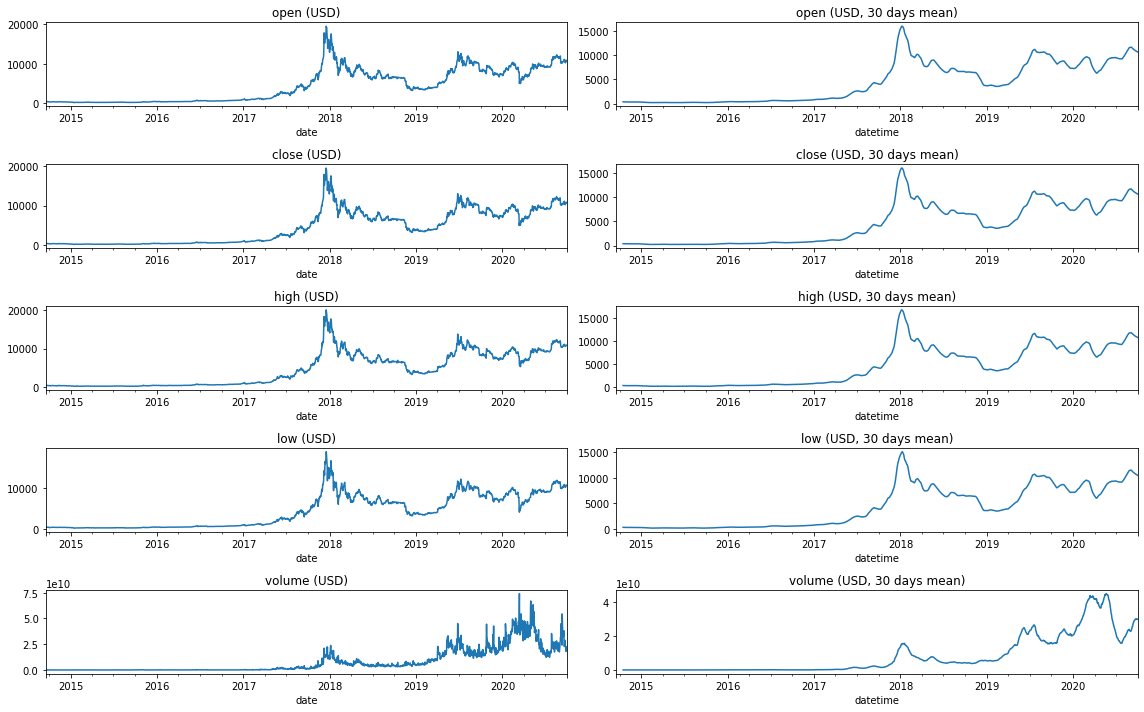

In [74]:
fig, axes = plt.subplots(nrows=len(plot_cols), ncols=2, figsize=(16,10))

for j in range(len(plot_cols)):
        plot_features.iloc[:,j].plot(ax=axes[j,0])
        axes[j,0].set_title(plot_cols[j] + ' (USD)')
        axes[j,0].set_xlabel('date')
        axes[j,1].set_title(plot_cols[j] + f' (USD, {window} days mean)')
        axes[j,1].set_xlabel('date')
        plot_rolling.iloc[:,j].plot(ax=axes[j,1])
        plt.tight_layout()
        
        

As we can see from the graphs, there isn't any intuitive shape. This can be easily seen analizing armonics components with fourier tranformation.

### Split de data

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [11]:
train_cols = ['open', 'close', 'high', 'low', 'volume']

df = df_btcusd[train_cols]

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [12]:
df

,open,close,high,low,volume
datetime,,,,,
2014-09-17,465.864014,457.334015,468.174011,452.421997,2.105680e+07
2014-09-18,456.859985,424.440002,456.859985,413.104004,3.448320e+07
2014-09-19,424.102997,394.795990,427.834991,384.532013,3.791970e+07
2014-09-20,394.673004,408.903992,423.295990,389.882996,3.686360e+07
2014-09-21,408.084991,398.821014,412.425995,393.181000,2.658010e+07
...,...,...,...,...,...
2020-09-25,10747.472656,10702.290039,10757.548828,10594.047852,2.123255e+10
2020-09-26,10702.237305,10754.437500,10778.500000,10682.082031,1.810501e+10
2020-09-27,10752.939453,10774.426758,10804.732422,10643.458008,1.801688e+10


### Normalize de data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. 

In [13]:
class DFMinMaxScaler(BaseEstimator, TransformerMixin):
    '''
    Class used for computing MinMaxScaler on a pandas df 
    ----------
    Returns
    -------
    X : pd.DataFrame with normalized columns 
    '''

    def __init__(self):
        pass
    
    def fit(self, train_df, y=None):
        self.max_train = train_df.max()
        self.min_train = train_df.min()      
        return self

    def transform(self, df, y=None):

        # make sure that the imputer was fitted
        check_is_fitted(self, ['min_train', 'max_train'])

        df = df.copy()
        scaled_df = (df - self.min_train) / (self.max_train - self.min_train)
        return scaled_df
    
    def inverse_transform(self, df, y=None):
        df_unscaled = df * (self.max_train - self.min_train) + self.min_train
        return df_unscaled
        

In [14]:
mm_sc = DFMinMaxScaler()
train_df_sc = mm_sc.fit_transform(train_df)
test_df_sc = mm_sc.transform(test_df)
val_df_sc = mm_sc.transform(val_df)

In [15]:
train_df_sc

,open,close,high,low,volume
datetime,,,,,
2014-09-17,0.014973,0.014453,0.012901,0.014940,0.000336
2014-09-18,0.014507,0.012751,0.012332,0.012849,0.000633
2014-09-19,0.012809,0.011216,0.010872,0.011329,0.000710
2014-09-20,0.011284,0.011947,0.010644,0.011614,0.000686
2014-09-21,0.011979,0.011425,0.010097,0.011789,0.000458
...,...,...,...,...,...
2019-07-12,0.579173,0.602397,0.588298,0.585432,0.521704
2019-07-13,0.602948,0.580470,0.585102,0.571037,0.466448
2019-07-14,0.580558,0.521652,0.565444,0.535196,0.498452


## Data windowing

A common aproach for predicting time series is making windows of data. This means making samples of windows like the following:

- Window 1: t0 + window size
- Window 2: t0 + window size + (2-1)*slide
- ...
- Window n: t0 + window size + n*slide

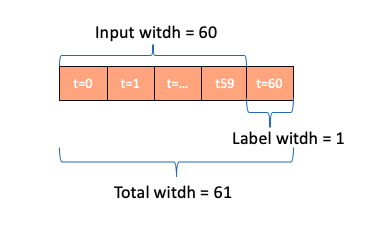

To make it even more clear, let's picture it in a dataframe. With a window with total width = 5 samples, splitted in:

- Input width = 4.
- Slide (between windows) = 1.
- Label width = 1. This means that with last 4 days (input), we'll try to predict fifth day.

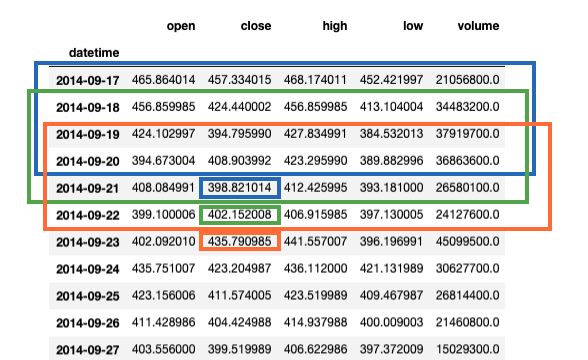

### 1. Indexes and offsets

Creating the WindowGenerator class. The __init__ method includes all the necessary logic for the input and label indices.

It also takes the train, eval, and test dataframes as input. These will be converted to tf.data.Datasets of windows later.

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                   train_df=train_df, val_df=val_df, test_df=test_df,
                   label_columns=None):
            
            # Store the raw data.
            self.train_df = train_df
            self.val_df = val_df
            self.test_df = test_df

            # Work out the label column indices.
            self.label_columns = label_columns
            if label_columns is not None:              
                self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
            self.column_indices = {name: i for i, name in
                                   enumerate(train_df.columns)}

            # Work out the window parameters.
            self.input_width = input_width
            self.label_width = label_width
            self.shift = shift

            self.total_window_size = input_width + shift

            self.input_slice = slice(0, input_width)
            self.input_indices = np.arange(self.total_window_size)[self.input_slice]

            self.label_start = self.total_window_size - self.label_width
            self.labels_slice = slice(self.label_start, None)
            self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):        
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [17]:
w1 = WindowGenerator(input_width=60, label_width=1, shift=1, train_df=train_df_sc,
                     test_df=test_df_sc, val_df=val_df_sc, label_columns=['close'])
w1

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [60]
Label column name(s): ['close']

### 2. Split

Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

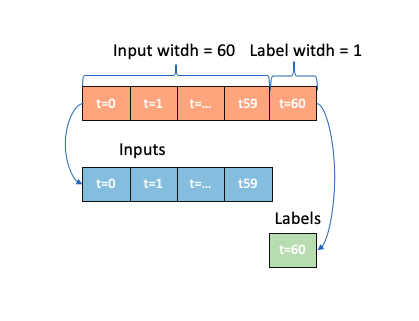

In [18]:
def split_window(self, features):   
    """
    Split an array of shape (batch size, window size aka time steps, feature size) into a tuple of input and label
    for training.
    :param features: array ofshape (batch size, window size aka time steps, feature size)
    :return: tuple with inputs and labels for training
    """  
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:       
        labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)
  
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [19]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df_sc[:w1.total_window_size]),
                           np.array(train_df_sc[100:100+w1.total_window_size]),
                           np.array(train_df_sc[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 61, 5)
Inputs shape: (3, 60, 5)
labels shape: (3, 1, 1)


In [20]:
w1.example = example_inputs, example_labels

In [21]:
def plot(self, model=None, plot_col='close', max_subplots=3):
    
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:            
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

    if n == 0:
        
        plt.legend()

    plt.xlabel('days')

WindowGenerator.plot = plot

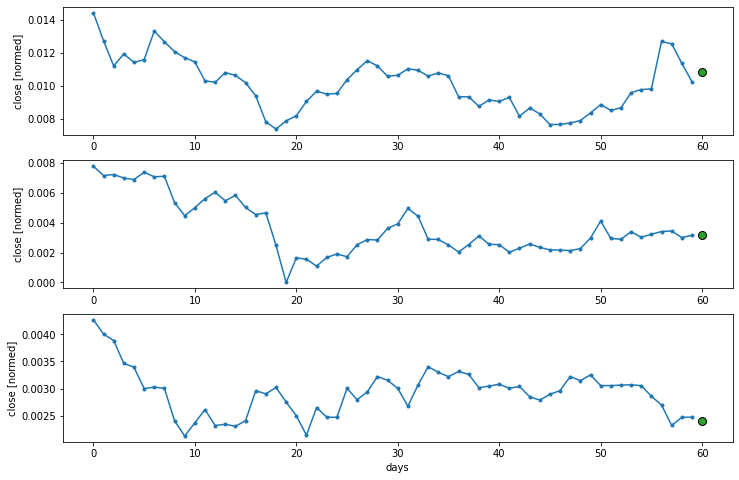

In [22]:
w1.plot()

In [23]:
# Batch size for training our LSTM model.
BATCH_SIZE = 10

# This constant is used in to make batches with equal batch size. It's needed for stateful LSTM models.
EQUAL_BATCH_SIZE = True

def reshape_batch_dataset(x, y):
    """
    This function is used to filter tensorflow dataset that doesn't have same batch size.
    :param data: tuple with (batch size, time steps, features)
    :return: true if batch size is equal to constant BATCH_SIZE, else returns false
    """   
    
    return len(x) == BATCH_SIZE

def make_dataset(self, data, sequence_stride=1):
    """
    Converts dataframe into timeseries format and supervised data format. Takes total window width 
    :param data: dataframe which holds the dataset
    :param sequence_stride: Period between successive output sequences. For stride s, output samples would start at index data[i], data[i + s], data[i + 2 * s], etc.
    :return: returns tensorflow dataset-- input and output in format suitable to feed
    to LSTM. 
    """       
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=sequence_stride,
        shuffle=False,
        batch_size=BATCH_SIZE,)

    ds = ds.map(self.split_window)

    if EQUAL_BATCH_SIZE:
          ds = ds.filter(reshape_batch_dataset)

    return ds

WindowGenerator.make_dataset = make_dataset

In [24]:
@property
def train(self):   
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self): 
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [25]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 60, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [26]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (10, 60, 5)
Labels shape (batch, time, features): (10, 1, 1)


## Predicting cryptocurrency future price

In [48]:
#Configuration for training

params = {
    "lr": 0.0010000,
    "epochs": 300,
}

In [49]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [50]:

def compile_and_fit(model, window, patience=40, min_delta=0.0001):    
    """
    Converts dataframe into timeseries format and supervised data format. Takes total window width 
    :param model: model to be compiled and fitted
    :param window: object from WindowGenerator Class.
    :param patience: Number of epochs with no improvement after which training will be stopped.
    :param min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
    :return: history object  
    """    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    min_delta=min_delta,
                                                    mode='min')
    
    # Store logs for tensorboard
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # Callback to store metrics that are used by tensorboard.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  
    optimizer = optimizers.RMSprop(lr=params["lr"])
    #optimizer = optimizers.SGD()
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                   optimizer=optimizer,
                   metrics=[tf.metrics.MeanAbsoluteError()]
                 )
    
    history = model.fit(window.train, epochs=params["epochs"],
                      validation_data=window.val,
                      callbacks=[early_stopping, tensorboard_callback], verbose=2)
    return history

### Base model

In [51]:
class MultiStepLastBaseline(tf.keras.Model):  
    def fit(self, window):
        self.window = window
    def call(self, inputs): 
        labels = tf.stack(
        [inputs[:,-1:, self.window.column_indices[name]] for name in self.window.label_columns],
        axis = -1)
        return tf.tile(labels, [1, OUT_STEPS, 1])
    

### LSTM model

In [52]:
def create_model(window):
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(120, stateful=True, return_sequences=True,
                            kernel_initializer='random_uniform', batch_input_shape=(BATCH_SIZE, INPUT_WINDOW, num_features)),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.LSTM(60, return_sequences=False),

        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(20, activation='relu'),

        tf.keras.layers.Dense(OUT_STEPS * len(window.label_columns)),
        tf.keras.layers.Reshape([OUT_STEPS, len(window.label_columns)])
    ])
    return model


## Single output prediction

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]
Label column name(s): ['close']

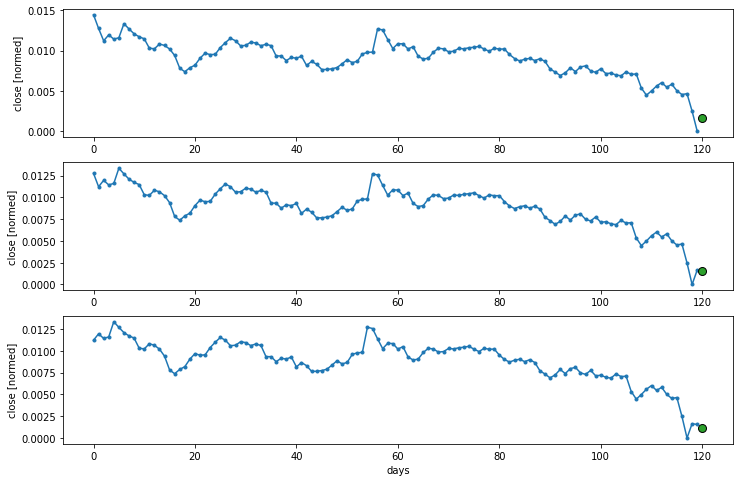

In [53]:
INPUT_WINDOW = 120
OUT_STEPS = 1

multi_window = WindowGenerator(input_width=INPUT_WINDOW,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_sc,
                               test_df=test_df_sc, 
                               val_df=val_df_sc,
                               label_columns=['close']
                              )

multi_window.plot()
multi_window

### Baseline prediction

10/10 [==============================] 1.2156e-04 - mean_absolute_error: 0.009 - 0s 2ms/step - loss: 1.2437e-04 - mean_absolute_error: 0.0083


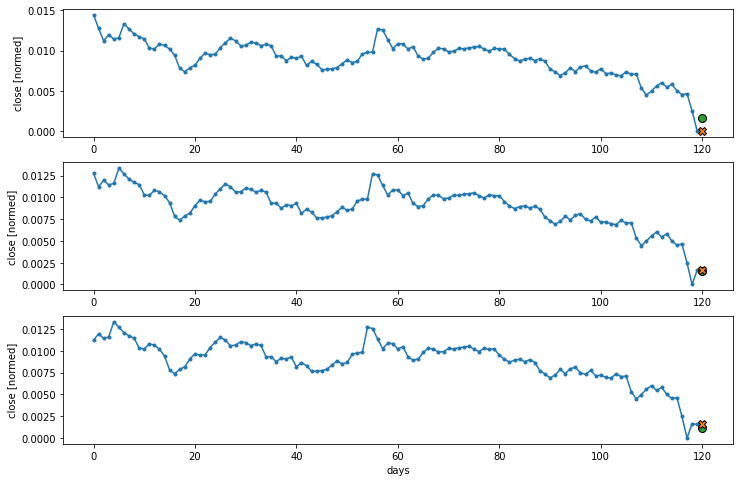

In [54]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

last_baseline.fit(multi_window)

multi_test_performance = {}
multi_val_performance = {}
multi_performance = {}

multi_test_performance['Last'] = last_baseline.evaluate(multi_window.test)
multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.train, verbose=0)
multi_window.plot(last_baseline)

### LSTM prediction

In [55]:

multi_lstm_model = create_model(multi_window)

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_test_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test)
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)

#multi_window.plot(multi_lstm_model)

10/10 [==============================] 6.7972e-04 - mean_absolute_error: 0.023 - 0s 9ms/step - loss: 5.7022e-04 - mean_absolute_error: 0.021 - 0s 10ms/step - loss: 7.9290e-04 - mean_absolute_error: 0.0252


In [56]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (10, 120, 120)            60480     
_________________________________________________________________
dropout_2 (Dropout)          (10, 120, 120)            0         
_________________________________________________________________
lstm_3 (LSTM)                (10, 60)                  43440     
_________________________________________________________________
dropout_3 (Dropout)          (10, 60)                  0         
_________________________________________________________________
dense_2 (Dense)              (10, 20)                  1220      
_________________________________________________________________
dense_3 (Dense)              (10, 1)                   21        
_________________________________________________________________
reshape_1 (Reshape)          (10, 1, 1)               

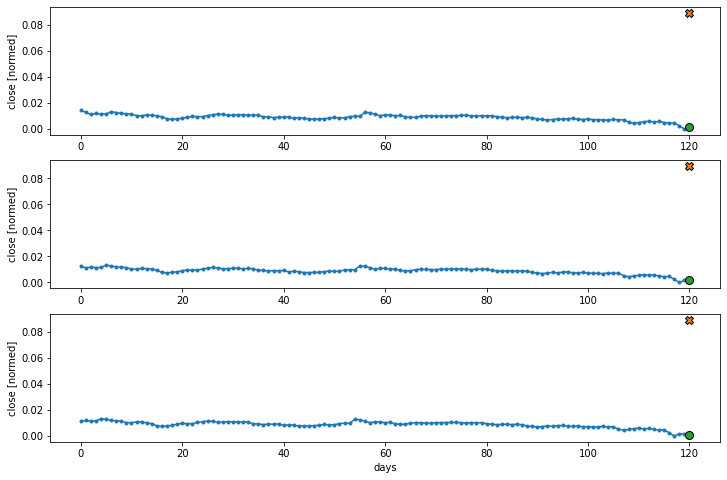

In [57]:
multi_window.plot(multi_lstm_model)

In [58]:
#  performance
single_step_performance_train = pd.DataFrame(multi_performance, index=['mse_train', 'mae_train'])
single_step_performance_val = pd.DataFrame(multi_val_performance, index=['mse_val', 'mae_val'])
single_step_performance_test = pd.DataFrame(multi_test_performance, index=['mse_test', 'mae_test'])
pd.concat([single_step_performance_train, single_step_performance_val, single_step_performance_test])

,Last,LSTM
mse_train,0.000218,0.004019
mae_train,0.006029,0.053534
mse_val,0.000124,0.000793
mae_val,0.008322,0.025238
mse_test,0.000185,0.002834
mae_test,0.008833,0.051136


#### LSTM prediction unscaled data

In [62]:
y_test = np.concatenate(list(multi_window.train.map(lambda x, y: y).unbatch().as_numpy_iterator())).flatten()
y_test_unscaled = y_test * (mm_sc.max_train[1] - mm_sc.min_train[1]) + mm_sc.min_train[1]

In [63]:
y_test_pred = multi_lstm_model.predict(multi_window.train.map(lambda x, y: x)).flatten()
y_test_pred_unscaled = y_test_pred * (mm_sc.max_train[1] - mm_sc.min_train[1]) + mm_sc.min_train[1]

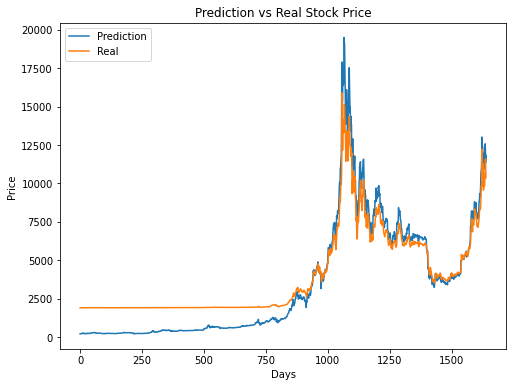

In [64]:
plt.figure()
plt.plot(y_test_unscaled)
plt.plot(y_test_pred_unscaled)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')

##### first configuration. input window = 1

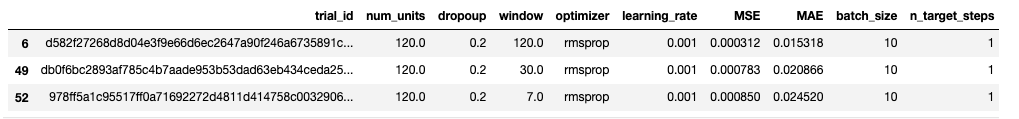

In [42]:
input_window_1 = y_test_pred_unscaled

##### first configuration. input window = 7

In [56]:
input_window_7 = y_test_pred_unscaled

In [57]:
performance_7 = pd.concat([single_step_performance_train, single_step_performance_val, single_step_performance_test])

##### first configuration. input window = 30

In [67]:
input_window_30 = y_test_pred_unscaled
performance_30 = pd.concat([single_step_performance_train, single_step_performance_val, single_step_performance_test])

## MULTI OUTPUT STEP

 ### Two day prediction

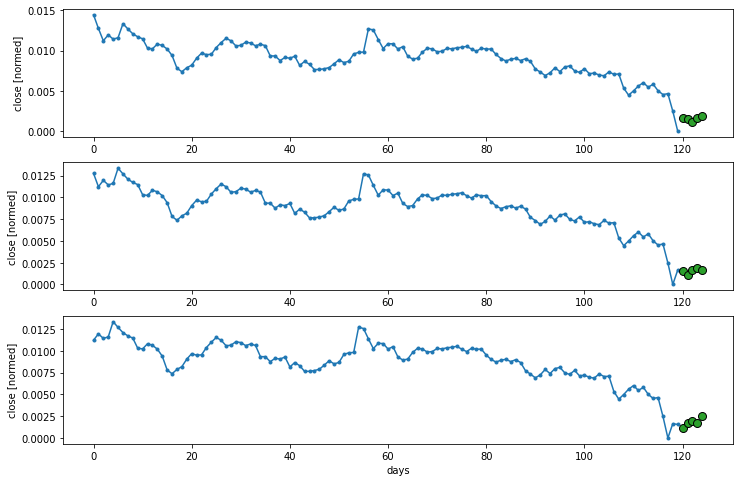

In [41]:
INPUT_WINDOW = 120
OUT_STEPS = 5

multi_output_window = WindowGenerator(input_width=INPUT_WINDOW,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_sc,
                               test_df=test_df_sc, 
                               val_df=val_df_sc,
                               label_columns=['close']
                              )

multi_output_window.plot()


### Base model

9/9 [==============================]s: 6.5371e-04 - mean_absolute_error: 0.019 - 0s 2ms/step - loss: 3.6924e-04 - mean_absolute_error: 0.0143


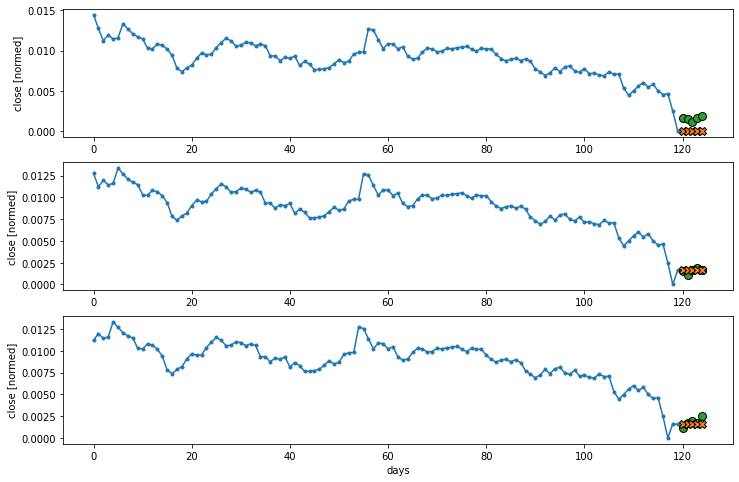

In [42]:
multi_last_baseline = MultiStepLastBaseline()
multi_last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

multi_last_baseline.fit(multi_window)

multi_test_performance = {}
multi_val_performance = {}
multi_performance = {}

multi_test_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.test)
multi_val_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.val)
multi_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.train, verbose=0)
multi_output_window.plot(multi_last_baseline)

### LSTM model

In [43]:
multi_output_lstm_model = create_model(multi_output_window)

history = compile_and_fit(multi_output_lstm_model, multi_output_window)

IPython.display.clear_output()

multi_test_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.test)
multi_val_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.val)
multi_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.train, verbose=0)

9/9 [==============================]s: 0.0051 - mean_absolute_error: 0.068 - 0s 10ms/step - loss: 0.0052 - mean_absolute_error: 0.070 - 0s 12ms/step - loss: 0.0041 - mean_absolute_error: 0.060 - 0s 12ms/step - loss: 0.0041 - mean_absolute_error: 0.0601


In [44]:
#  performance
multi_step_performance_train = pd.DataFrame(multi_performance, index=['mse_train', 'mae_train'])
multi_step_performance_val = pd.DataFrame(multi_val_performance, index=['mse_val', 'mae_val'])
multi_step_performance_test = pd.DataFrame(multi_test_performance, index=['mse_test', 'mae_test'])
pd.concat([multi_step_performance_train, multi_step_performance_val, multi_step_performance_test])

,Last,LSTM
mse_train,0.000665,0.003802
mae_train,0.010653,0.055316
mse_val,0.000369,0.004069
mae_val,0.014317,0.060063
mse_test,0.000501,0.000929
mae_test,0.014209,0.025995


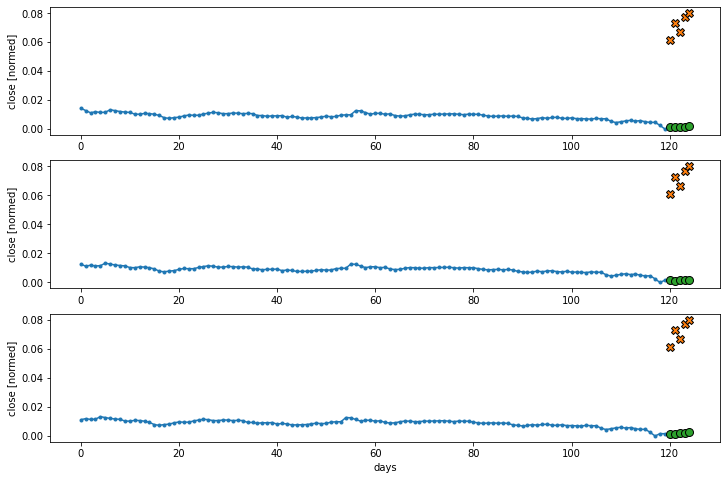

In [45]:
multi_output_window.plot(multi_output_lstm_model)

 ### Muti day prediction

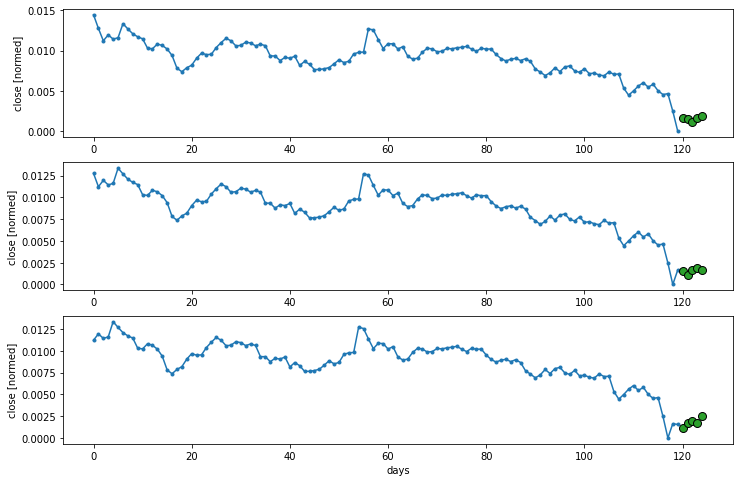

In [46]:
INPUT_WINDOW = 120
OUT_STEPS = 5

multi_output_window = WindowGenerator(input_width=INPUT_WINDOW,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_sc,
                               test_df=test_df_sc, 
                               val_df=val_df_sc,
                               label_columns=['close']
                              )

multi_output_window.plot()


### Base model

9/9 [==============================]s: 6.5371e-04 - mean_absolute_error: 0.019 - 0s 1ms/step - loss: 3.6924e-04 - mean_absolute_error: 0.0143


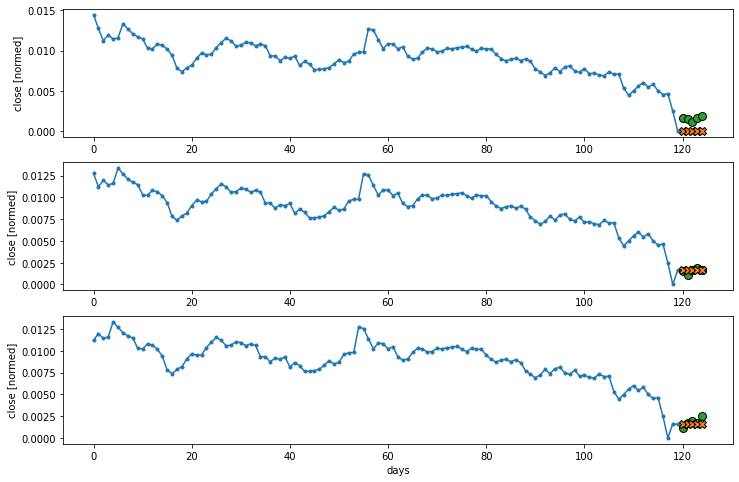

In [47]:
multi_last_baseline = MultiStepLastBaseline()
multi_last_baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

multi_last_baseline.fit(multi_window)

multi_test_performance = {}
multi_val_performance = {}
multi_performance = {}

multi_test_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.test)
multi_val_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.val)
multi_performance['Last'] = multi_last_baseline.evaluate(multi_output_window.train, verbose=0)
multi_output_window.plot(multi_last_baseline)

### LSTM model

In [48]:
multi_output_lstm_model = create_model(multi_output_window)

history = compile_and_fit(multi_output_lstm_model, multi_output_window)

IPython.display.clear_output()

multi_test_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.test)
multi_val_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.val)
multi_performance['LSTM'] = multi_output_lstm_model.evaluate(multi_output_window.train, verbose=0)

9/9 [==============================]s: 5.2165e-04 - mean_absolute_error: 0.016 - 0s 10ms/step - loss: 4.3552e-04 - mean_absolute_error: 0.017 - 0s 11ms/step - loss: 5.4299e-04 - mean_absolute_error: 0.0187


In [49]:
#  performance
multi_step_performance_train = pd.DataFrame(multi_performance, index=['mse_train', 'mae_train'])
multi_step_performance_val = pd.DataFrame(multi_val_performance, index=['mse_val', 'mae_val'])
multi_step_performance_test = pd.DataFrame(multi_test_performance, index=['mse_test', 'mae_test'])
pd.concat([multi_step_performance_train, multi_step_performance_val, multi_step_performance_test])

,Last,LSTM
mse_train,0.000665,0.003666
mae_train,0.010653,0.045556
mse_val,0.000369,0.000543
mae_val,0.014317,0.018745
mse_test,0.000501,0.004981
mae_test,0.014209,0.063293


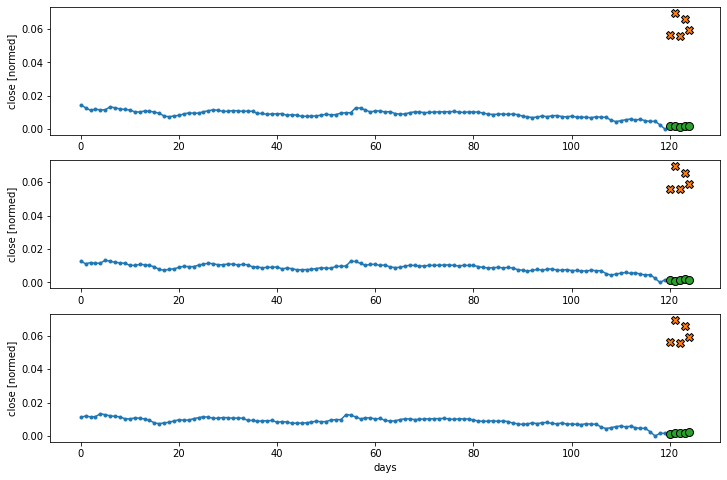

In [50]:
multi_output_window.plot(multi_output_lstm_model)

## HYPERPARAM TUNNING

In [51]:
from tensorboard.plugins.hparams import api as hp

In [52]:
#HP_BACH_SIZE = hp.HParam('batch_size', hp.Discrete([1, 10, 16, 20, 32]))

In [53]:
# Number of labels (future timesteps) to predict
OUT_STEPS = 5

# Size of the input window, in days.
HP_INPUT_WINDOW = hp.HParam('window', hp.Discrete([2, 7, 30, 60, 90, 120]))

#Grid Search parameters.

#Number of LSTM UNITS
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([100, 120]))

#Dropout rate.
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.0, 0.5))

#Optimizer
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['rmsprop']))

#Batch size

HP_BACH_SIZE = hp.HParam('batch_size', hp.Discrete([5, 10, 20, 32]))

#Learning rate
HP_L_RATE = hp.HParam('learning_rate', hp.Discrete([0.0001, 0.001]))

METRIC_MSE = 'mse'
METRIC_MAE = 'mae'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_INPUT_WINDOW, HP_OPTIMIZER, HP_L_RATE, HP_BACH_SIZE],
    metrics=[hp.Metric(METRIC_MSE, display_name='MSE'), hp.Metric(METRIC_MAE, display_name='MAE')],
  )

In [54]:
MAX_EPOCHS = 300

def train_test_model(hparams, patience=40, min_delta=0.0001):
 
    global BATCH_SIZE
    BATCH_SIZE =  hparams[HP_BACH_SIZE]
    window = WindowGenerator(input_width=hparams[HP_INPUT_WINDOW],
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df_sc,
                               test_df=test_df_sc, 
                               val_df=val_df_sc,
                               label_columns=['close']
                              )
       
    model = tf.keras.Sequential([
        # Shape [batch, time, features] => [batch, lstm_units]
        # Adding more `lstm_units` just overfits more quickly.
        tf.keras.layers.LSTM(hparams[HP_NUM_UNITS], stateful=True, return_sequences=True,
                            kernel_initializer='random_uniform', batch_input_shape=(hparams[HP_BACH_SIZE], hparams[HP_INPUT_WINDOW], num_features)),

        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),

        tf.keras.layers.LSTM(60, dropout=0.0),

        tf.keras.layers.Dropout(hparams[HP_DROPOUT]),

        tf.keras.layers.Dense(20, activation='relu'),

        tf.keras.layers.Dense(OUT_STEPS * len(window.label_columns)),

        tf.keras.layers.Reshape([OUT_STEPS, len(window.label_columns)])
    ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    min_delta=min_delta,
                                                    mode='min')

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    optimizer_name = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_L_RATE]
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("unexpected optimizer name: %r" % (optimizer_name,))
    
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=optimizer,
                metrics=[tf.metrics.MeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()])

    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping, tensorboard_callback], use_multiprocessing=True, verbose=0)

#    history = model.fit(window.train, epochs=MAX_EPOCHS,
#                      validation_data=window.val,
#                      callbacks=[early_stopping, tensorboard_callback], use_multiprocessing=True)
    _, mse, mae = model.evaluate(window.val, use_multiprocessing=True, verbose=0)
    
    return mse, mae

In [55]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():       
        hp.hparams(hparams)  # record the values used in this trial
        mse, mae = train_test_model(hparams)
        tf.summary.scalar(METRIC_MSE, mse, step=1)
        tf.summary.scalar(METRIC_MAE, mae, step=2)

In [56]:
session_num = 0
for window in HP_INPUT_WINDOW.domain.values:
    
    for batch_size in HP_BACH_SIZE.domain.values:
        
        for num_units in HP_NUM_UNITS.domain.values:
            
            for dropout_rate in np.arange(HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value,0.1):
                
                for optimizer in HP_OPTIMIZER.domain.values:
                    
                    for learning_rate in HP_L_RATE.domain.values:
                        
                        hparams = {
                              HP_NUM_UNITS: num_units,
                              HP_DROPOUT: dropout_rate,
                              HP_INPUT_WINDOW: window,
                              HP_OPTIMIZER: optimizer,
                              HP_BACH_SIZE: batch_size,
                              HP_L_RATE: learning_rate
                          }
                        run_name = "run-%d" % session_num
                        print('--- Starting trial: %s' % run_name)
                        print({h.name: hparams[h] for h in hparams})
                        run('logs/hparam_tuning/' + run_name, hparams)
                        session_num += 1
            
IPython.display.clear_output()

--- Starting trial: run-0
{'num_units': 100, 'dropout': 0.0, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.0001}
[2020-09-27 20:30:42,387] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0037s vs `on_train_batch_end` time: 0.1181s). Check your callbacks.
--- Starting trial: run-1
{'num_units': 100, 'dropout': 0.0, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.001}
[2020-09-27 20:31:42,634] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.1310s). Check your callbacks.
--- Starting trial: run-2
{'num_units': 100, 'dropout': 0.1, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.0001}
[2020-09-27 20:33:21,635] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0029s vs `on_tra

[2020-09-27 20:49:57,650] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0030s vs `on_train_batch_end` time: 0.1263s). Check your callbacks.
--- Starting trial: run-16
{'num_units': 120, 'dropout': 0.30000000000000004, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.0001}
[2020-09-27 20:51:12,863] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0038s vs `on_train_batch_end` time: 0.1142s). Check your callbacks.
--- Starting trial: run-17
{'num_units': 120, 'dropout': 0.30000000000000004, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.001}
[2020-09-27 20:52:51,068] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_train_batch_end` time: 0.1195s). Check your callbacks.
--- Starting trial: run-18
{'num_units': 120, 'dropout

[2020-09-27 21:17:00,930] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0042s vs `on_train_batch_end` time: 0.1303s). Check your callbacks.
--- Starting trial: run-47
{'num_units': 100, 'dropout': 0.30000000000000004, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.001}
[2020-09-27 21:17:48,081] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0033s vs `on_train_batch_end` time: 0.1352s). Check your callbacks.
--- Starting trial: run-48
{'num_units': 100, 'dropout': 0.4, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.0001}
[2020-09-27 21:18:24,632] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.1258s). Check your callbacks.
--- Starting trial: run-49
{'num_units': 100, 'dropout': 0.4, 'windo

[2020-09-27 21:37:40,065] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0037s vs `on_train_batch_end` time: 0.1502s). Check your callbacks.
--- Starting trial: run-78
{'num_units': 120, 'dropout': 0.4, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.0001}
[2020-09-27 21:38:04,067] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0041s vs `on_train_batch_end` time: 0.1228s). Check your callbacks.
--- Starting trial: run-79
{'num_units': 120, 'dropout': 0.4, 'window': 2, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.001}
[2020-09-27 21:38:50,917] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0058s vs `on_train_batch_end` time: 0.1552s). Check your callbacks.
--- Starting trial: run-80
{'num_units': 100, 'dropout': 0.0, 'window': 7, 'optimize

[2020-09-27 22:35:30,383] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_train_batch_end` time: 0.1349s). Check your callbacks.
--- Starting trial: run-109
{'num_units': 100, 'dropout': 0.4, 'window': 7, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.001}
[2020-09-27 22:37:20,287] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0075s vs `on_train_batch_end` time: 0.1499s). Check your callbacks.
--- Starting trial: run-110
{'num_units': 120, 'dropout': 0.0, 'window': 7, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-27 22:38:46,683] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0072s vs `on_train_batch_end` time: 0.1340s). Check your callbacks.
--- Starting trial: run-111
{'num_units': 120, 'dropout': 0.0, 'window': 7, 'optim

[2020-09-27 23:12:41,520] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0074s vs `on_train_batch_end` time: 0.1610s). Check your callbacks.
--- Starting trial: run-140
{'num_units': 100, 'dropout': 0.0, 'window': 7, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.0001}
[2020-09-27 23:14:18,672] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0090s vs `on_train_batch_end` time: 0.1309s). Check your callbacks.
--- Starting trial: run-141
{'num_units': 100, 'dropout': 0.0, 'window': 7, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.001}
[2020-09-27 23:14:50,273] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0088s vs `on_train_batch_end` time: 0.1660s). Check your callbacks.
--- Starting trial: run-142
{'num_units': 100, 'dropout': 0.1, 'window': 7, 'optim

[2020-09-28 00:11:24,648] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0255s vs `on_train_batch_end` time: 0.1882s). Check your callbacks.
--- Starting trial: run-171
{'num_units': 120, 'dropout': 0.0, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.001}
[2020-09-28 00:14:17,452] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.2062s). Check your callbacks.
--- Starting trial: run-172
{'num_units': 120, 'dropout': 0.1, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.0001}
[2020-09-28 00:20:28,852] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.2041s). Check your callbacks.
--- Starting trial: run-173
{'num_units': 120, 'dropout': 0.1, 'window': 30, 'opti

[2020-09-28 02:22:49,337] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0213s vs `on_train_batch_end` time: 0.2288s). Check your callbacks.
--- Starting trial: run-202
{'num_units': 100, 'dropout': 0.1, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.0001}
[2020-09-28 02:25:54,391] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.2200s). Check your callbacks.
--- Starting trial: run-203
{'num_units': 100, 'dropout': 0.1, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.001}
[2020-09-28 02:28:42,307] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.1921s). Check your callbacks.
--- Starting trial: run-204
{'num_units': 100, 'dropout': 0.2, 'window': 30, 'op

[2020-09-28 03:30:59,269] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0209s vs `on_train_batch_end` time: 0.1922s). Check your callbacks.
--- Starting trial: run-232
{'num_units': 120, 'dropout': 0.1, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.0001}
[2020-09-28 03:32:47,329] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.1995s). Check your callbacks.
--- Starting trial: run-233
{'num_units': 120, 'dropout': 0.1, 'window': 30, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.001}
[2020-09-28 03:34:08,417] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0226s vs `on_train_batch_end` time: 0.1966s). Check your callbacks.
--- Starting trial: run-234
{'num_units': 120, 'dropout': 0.2, 'window': 30, 'op

--- Starting trial: run-262
{'num_units': 100, 'dropout': 0.1, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-28 07:43:48,955] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0510s vs `on_train_batch_end` time: 0.2562s). Check your callbacks.
--- Starting trial: run-263
{'num_units': 100, 'dropout': 0.1, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.001}
[2020-09-28 07:54:20,960] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0354s vs `on_train_batch_end` time: 0.2747s). Check your callbacks.
--- Starting trial: run-264
{'num_units': 100, 'dropout': 0.2, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-28 07:58:28,764] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0530

[2020-09-28 09:31:20,721] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0345s vs `on_train_batch_end` time: 0.2805s). Check your callbacks.
--- Starting trial: run-278
{'num_units': 120, 'dropout': 0.4, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-28 09:36:08,084] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0352s vs `on_train_batch_end` time: 0.2507s). Check your callbacks.
--- Starting trial: run-279
{'num_units': 120, 'dropout': 0.4, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.001}
[2020-09-28 09:43:40,542] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0339s vs `on_train_batch_end` time: 0.2567s). Check your callbacks.
--- Starting trial: run-280
{'num_units': 100, 'dropout': 0.0, 'window': 60, 'op

[2020-09-28 11:30:23,722] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0401s vs `on_train_batch_end` time: 0.2437s). Check your callbacks.
--- Starting trial: run-309
{'num_units': 100, 'dropout': 0.4, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.001}
[2020-09-28 11:34:01,324] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0445s vs `on_train_batch_end` time: 0.2537s). Check your callbacks.
--- Starting trial: run-310
{'num_units': 120, 'dropout': 0.0, 'window': 60, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.0001}
[2020-09-28 11:38:22,971] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0418s vs `on_train_batch_end` time: 0.2563s). Check your callbacks.
--- Starting trial: run-311
{'num_units': 120, 'dropout': 0.0, 'window': 60, 'op

[2020-09-28 16:24:09,404] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0453s vs `on_train_batch_end` time: 0.3408s). Check your callbacks.
--- Starting trial: run-340
{'num_units': 100, 'dropout': 0.0, 'window': 90, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-28 16:31:11,966] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0457s vs `on_train_batch_end` time: 0.3206s). Check your callbacks.
--- Starting trial: run-341
{'num_units': 100, 'dropout': 0.0, 'window': 90, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.001}
[2020-09-28 16:41:20,677] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0517s vs `on_train_batch_end` time: 0.3206s). Check your callbacks.
--- Starting trial: run-342
{'num_units': 100, 'dropout': 0.1, 'window': 90, 'op

[2020-09-28 20:20:23,036] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0782s vs `on_train_batch_end` time: 0.3475s). Check your callbacks.
--- Starting trial: run-371
{'num_units': 120, 'dropout': 0.0, 'window': 90, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.001}
[2020-09-28 20:25:22,622] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0553s vs `on_train_batch_end` time: 0.3162s). Check your callbacks.
--- Starting trial: run-372
{'num_units': 120, 'dropout': 0.1, 'window': 90, 'optimizer': 'rmsprop', 'batch_size': 20, 'learning_rate': 0.0001}
[2020-09-28 20:32:45,132] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0536s vs `on_train_batch_end` time: 0.3290s). Check your callbacks.
--- Starting trial: run-373
{'num_units': 120, 'dropout': 0.1, 'window': 90, 'op

[2020-09-28 22:58:15,104] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0507s vs `on_train_batch_end` time: 0.2106s). Check your callbacks.
--- Starting trial: run-402
{'num_units': 100, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.0001}
[2020-09-28 23:20:53,875] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0520s vs `on_train_batch_end` time: 0.1789s). Check your callbacks.
--- Starting trial: run-403
{'num_units': 100, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 5, 'learning_rate': 0.001}
[2020-09-28 23:29:57,451] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0415s vs `on_train_batch_end` time: 0.1993s). Check your callbacks.
--- Starting trial: run-404
{'num_units': 100, 'dropout': 0.2, 'window': 120, 'o

[2020-09-29 08:03:19,385] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0963s vs `on_train_batch_end` time: 0.2713s). Check your callbacks.
--- Starting trial: run-432
{'num_units': 120, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.0001}
[2020-09-29 12:56:26,578] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0495s vs `on_train_batch_end` time: 0.3542s). Check your callbacks.
--- Starting trial: run-433
{'num_units': 120, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 10, 'learning_rate': 0.001}
[2020-09-29 13:14:43,488] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0922s vs `on_train_batch_end` time: 0.2653s). Check your callbacks.
--- Starting trial: run-434
{'num_units': 120, 'dropout': 0.2, 'window': 120, 

[2020-09-29 16:37:08,265] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1668s vs `on_train_batch_end` time: 0.4288s). Check your callbacks.
--- Starting trial: run-462
{'num_units': 100, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.0001}
[2020-09-29 16:40:19,443] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0906s vs `on_train_batch_end` time: 0.2819s). Check your callbacks.
--- Starting trial: run-463
{'num_units': 100, 'dropout': 0.1, 'window': 120, 'optimizer': 'rmsprop', 'batch_size': 32, 'learning_rate': 0.001}
[2020-09-29 16:46:25,450] {callbacks.py:328} WARNING - Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0788s vs `on_train_batch_end` time: 0.2929s). Check your callbacks.
--- Starting trial: run-464
{'num_units': 100, 'dropout': 0.2, 'window': 120, 

KeyboardInterrupt: 

## SAVING THE MODEL

### SINGLE OUTPUT MODEL

In [ ]:
# Saving standarization object

joblib.dump(mm_sc, 'outputs/min_max_scaler.pkl')

# Saving window

joblib.dump(multi_window, 'outputs/multi_window_single_output.pkl')

In [ ]:
# Saving model

multi_lstm_model.save("outputs/lstm_model_single_output")

### MULTIOTPUT MODEL

In [ ]:
# Saving window

joblib.dump(multi_output_window, 'outputs/multi_output_window_ten.pkl')



In [ ]:
# Saving model

multi_output_lstm_model.save("outputs/multi_output_lstm_model_ten")